# Libraries

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import KBinsDiscretizer, StandardScaler
from sklearn.impute import SimpleImputer

from scipy.stats import ks_2samp
from varclushi import VarClusHi
from sklearn.feature_selection import VarianceThreshold

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
from sklearn.metrics import roc_auc_score,accuracy_score,confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve

from sklearn.metrics import plot_roc_curve

from sklearn.model_selection import train_test_split

In [2]:
pd.set_option('display.max_columns',500)

# Functions

In [3]:
# Requencies
def freq(df, var):
    if type(var) != list:
        var = [var]
    
    for v in var:
        aux = df[v].value_counts().to_frame().rename(columns={v:'FA'})
        aux['FR'] = aux['FA'] / aux['FA'].sum()
        aux[['FAA','FRA']] = aux.apply( np.cumsum )
        print(f"Frequencies table for variable {v} \n")    
        print(aux,"\n")

In [4]:
#Discretizing
def discretizar(df,v,k):
    
    kb = KBinsDiscretizer( n_bins= k , encode='ordinal', strategy='kmeans')
    kb.fit( df[[v]] )
    df[f'd_{v}_{k}']  = pd.cut( df[v], bins=kb.bin_edges_[0] , include_lowest=True  ).astype(str)
    
    return df

In [5]:
def calculo_iv(df, v, tgt , um):
    aux = df.pivot_table( index = v , 
                          columns = tgt , 
                          values = um , 
                         aggfunc = 'count', 
                         fill_value = 0 )
    
    aux[list(range(2))] = aux/aux.apply(np.sum)
    aux['w'] = np.log( aux[0] / aux[1] )
    aux['iv'] = ( aux[0] - aux[1] ) * aux['w']
    
    return v, aux['iv'].sum()

In [6]:
def codificacion_woe(df,v,tgt,um):
    
    aux = df.pivot_table(index=v,
                         columns=tgt,
                         values=um,
                         aggfunc='count',
                         fill_value=0)
    
    aux[list(range(2))] = aux/aux.apply(np.sum)
    
    aux['w'] = np.log(aux[0]/aux[1])
    
    aux.drop(range(2),axis=1,inplace=True)
    
    aux = aux.to_dict()['w']
    
    return v,aux

In [7]:
def metrics_Linear(y_true,y_pred):
    r2=r2_score(y_true,y_pred)
    mae=mean_absolute_error(y_true,y_pred)
    mse=mean_squared_error(y_true,y_pred)
    print(f'r2 score: {r2}')
    print(f'Mean squared error: {mse}')
    print(f'Mean absolute error: {mae}')

In [8]:
def metrics_Logistic(model,Xv,yv):
    print( " Roc Validate: %.3f" %roc_auc_score(y_score=model.predict_proba(Xv)[:,1],y_true=yv))
    print( " Acc Validate: %.3f" %accuracy_score(y_pred=model.predict(Xv),y_true=yv))
    print( " Matrix Conf Validate: ", "\n",confusion_matrix(y_pred=model.predict(Xv),y_true=yv))

# Data Reading

In [9]:
df = pd.read_csv("../Datasets/churn_p1.csv")

In [10]:
df.head()

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity OnlineBackup  \
0  No phone service             DSL             No          Yes   
1                No             DSL            Yes           No   
2                No             DSL            Yes          Yes   
3  No phone service             DSL            Yes           No   
4                No     Fiber optic             No           No   

  DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  \
0               No          No          No              No  Month-to-month   
1              Yes          No          No              No        One year   
2               No          No          No              No  Month-to-month   
3              Yes         Yes          No              No        One year   
4               No          No          No              No  Month-to-month   

  PaperlessBilling              PaymentMethod  MonthlyCharges TotalCharges  \
0              Yes           Electronic check           29.85        29.85   
1               No               Mailed check           56.95       1889.5   
2              Yes               Mailed check           53.85       108.15   
3               No  Bank transfer (automatic)           42.30      1840.75   
4              Yes           Electronic check           70.70       151.65   

  Churn  
0    No  
1    No  
2   Yes  
3    No  
4   Yes

# Cleaning/Pre-treatment

In [11]:
#every row has a unique User ID
df.shape, len(df.customerID.unique())

((7043, 21), 7043)

In [12]:
df.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [13]:
um = ["customerID"]
tgt = ["MonthlyCharges"]
varc = ["tenure", "TotalCharges"]
vard = [col for col in df.columns.to_list() if col not in (um+tgt+varc)]

In [14]:
df[varc].dtypes

tenure           int64
TotalCharges    object
dtype: object

In [15]:
df[vard].dtypes

gender              object
SeniorCitizen        int64
Partner             object
Dependents          object
PhoneService        object
MultipleLines       object
InternetService     object
OnlineSecurity      object
OnlineBackup        object
DeviceProtection    object
TechSupport         object
StreamingTV         object
StreamingMovies     object
Contract            object
PaperlessBilling    object
PaymentMethod       object
Churn               object
dtype: object

In [16]:
#There are missing values in the total charges variable, we can delete them as they will no affect our data
df[df["TotalCharges"] == ' '].shape, int(len(df[df["TotalCharges"] == ' '])/len(df))

((11, 21), 0)

In [17]:
df = df[df["TotalCharges"] != ' ']

df["TotalCharges"] = df["TotalCharges"].astype(float)

# Exploratory Analysis

## Discrete Var

### Replacing any NaN values for "Without_Category"

In [18]:
df.shape

(7032, 21)

In [19]:
for v in vard:
    df[v] = df[v].fillna("Without Category")

### Frequencies

In [20]:
# No value was replaced for "Without Category"
for v in vard:
    freq(df,v)

Frequencies table for variable gender 

          FA        FR   FAA       FRA
Male    3549  0.504693  3549  0.504693
Female  3483  0.495307  7032  1.000000 

Frequencies table for variable SeniorCitizen 

     FA      FR   FAA     FRA
0  5890  0.8376  5890  0.8376
1  1142  0.1624  7032  1.0000 

Frequencies table for variable Partner 

       FA        FR   FAA       FRA
No   3639  0.517491  3639  0.517491
Yes  3393  0.482509  7032  1.000000 

Frequencies table for variable Dependents 

       FA        FR   FAA       FRA
No   4933  0.701507  4933  0.701507
Yes  2099  0.298493  7032  1.000000 

Frequencies table for variable PhoneService 

       FA        FR   FAA       FRA
Yes  6352  0.903299  6352  0.903299
No    680  0.096701  7032  1.000000 

Frequencies table for variable MultipleLines 

                    FA        FR   FAA       FRA
No                3385  0.481371  3385  0.481371
Yes               2967  0.421928  6352  0.903299
No phone service   680  0.096701  7032  1.00000

### We don't need to normalize information as all categories are >= 5%

## Continuous Var

### Univariate Analysis

In [21]:
df.shape

(7032, 21)

In [22]:
df[varc].describe(percentiles=[0.01,0.1,0.9,0.99, 0.995]).T

count         mean          std   min    1%   10%       50%  \
tenure        7032.0    32.421786    24.545260   1.0   1.0   2.0    29.000   
TotalCharges  7032.0  2283.300441  2266.771362  18.8  19.9  84.6  1397.475   

                  90%       99%       99.5%     max  
tenure          69.00    72.000    72.00000    72.0  
TotalCharges  5976.64  8039.883  8304.72475  8684.8

array([[<AxesSubplot:title={'center':'tenure'}>,
        <AxesSubplot:title={'center':'TotalCharges'}>]], dtype=object)

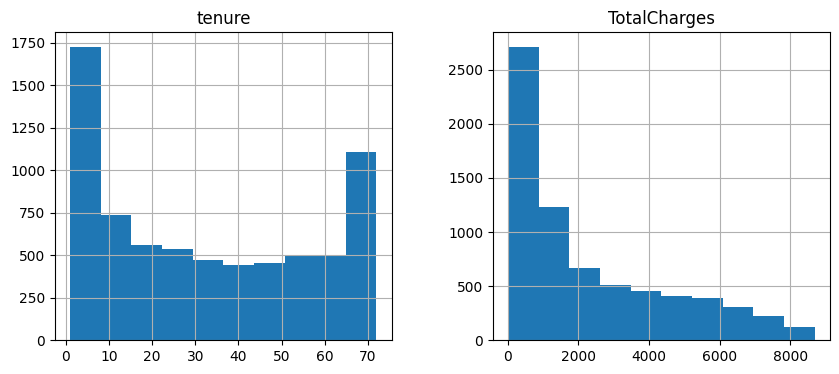

In [23]:
df[varc].hist(figsize=(10,4))

#### Missing Values

In [24]:
miss = 1 - df[varc].describe().T[['count']] / len(df)
miss

count
tenure          0.0
TotalCharges    0.0

#### Outliers

##### Cerca Intercuartil

In [25]:
k = 2
ext = df[varc].describe(percentiles=[0.25,0.75]).T[['25%','75%','mean']].reset_index()
ext['IQR'] = ext['75%'] - ext['25%'] 
ext['li']  = ext['mean'] - k*ext['IQR']
ext['ls']  = ext['mean'] + k*ext['IQR']
ext = ext[['index','li','ls']]

In [26]:
for v, li, ls in ext.values:
    df[f'ol_{v}'] = (( df[v] < li ) | ( df[v] > ls ) ).astype(int)

df['ext_iqr'] =  df.filter(like='ol_').max(axis=1)
df.drop(df.filter(like='ol_').columns, axis=1 , inplace=True)

In [27]:
df['ext_iqr'].value_counts()

0    7032
Name: ext_iqr, dtype: int64

##### Cerca Percentil

In [28]:
ext = df[varc].describe(percentiles=[0.005,0.995]).T[['0.5%','99.5%']].reset_index()
for v, li, ls in ext.values:
    df[f'ol_{v}'] = ( (df[v]<li) | (df[v]>ls)  ).astype(int)
    
df['ext'] = df.filter(like='ol_').max(axis=1)

In [29]:
df.drop(df.filter(like='ol_').columns, axis=1, inplace=True)

In [30]:
df['ext'].value_counts(True)

0    0.989903
1    0.010097
Name: ext, dtype: float64

##### Deleting Outliers

In [31]:
# We stay with the "Cerca Percentil" Methodology
df =df.loc[df["ext"] == 0].reset_index(drop=True).drop(["ext", "ext_iqr"], axis=1)

In [32]:
df.shape

(6961, 21)

array([[<AxesSubplot:title={'center':'tenure'}>,
        <AxesSubplot:title={'center':'TotalCharges'}>]], dtype=object)

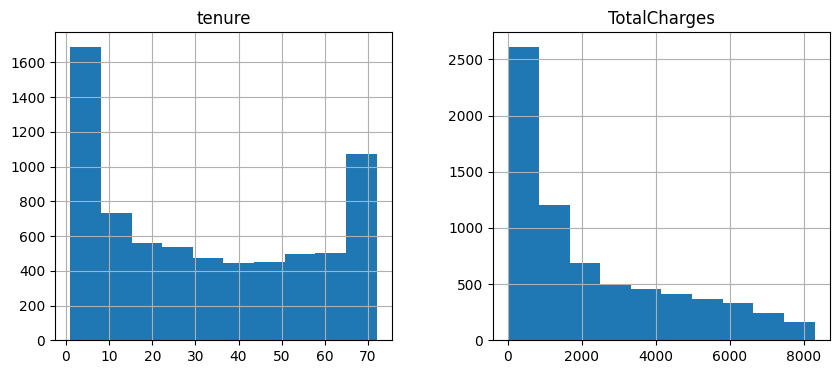

In [33]:
df[varc].hist(figsize=(10,4))

### Bivariate Analysis

In [34]:
df[varc].corr()

tenure  TotalCharges
tenure        1.000000      0.823628
TotalCharges  0.823628      1.000000

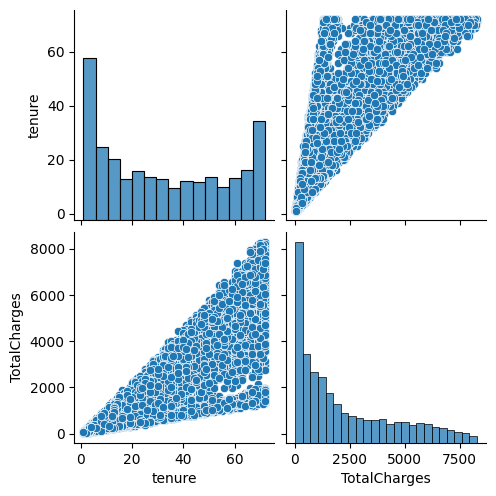

In [35]:
sns.pairplot(df[varc])

In [36]:
vc = VarClusHi(df=df[varc], feat_list = varc)
vc.varclus()

In [37]:
rs = vc.rsquare
rs = rs.sort_values(by=['Cluster','RS_Ratio'] , ascending=[1,1]).reset_index(drop=True)

In [38]:
rs['id'] = rs.groupby('Cluster').cumcount()+1

In [39]:
rs

Cluster      Variable    RS_Own  RS_NC  RS_Ratio  id
0        0        tenure  0.911814      0  0.088186   1
1        0  TotalCharges  0.911814      0  0.088186   2

array([[<AxesSubplot:title={'center':'tenure'}>]], dtype=object)

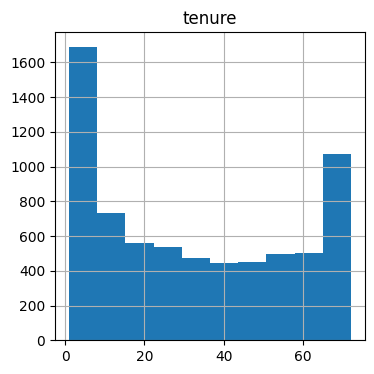

In [40]:
varc = rs.loc[ rs['id'] == 1 ]['Variable'].tolist()
df[varc].hist(figsize=(4,4))

# Linear Regression

## Dummies

In [41]:
dummies = pd.get_dummies(df[vard])

dummies.head()

SeniorCitizen  gender_Female  gender_Male  Partner_No  Partner_Yes  \
0              0              1            0           0            1   
1              0              0            1           1            0   
2              0              0            1           1            0   
3              0              0            1           1            0   
4              0              1            0           1            0   

   Dependents_No  Dependents_Yes  PhoneService_No  PhoneService_Yes  \
0              1               0                1                 0   
1              1               0                0                 1   
2              1               0                0                 1   
3              1               0                1                 0   
4              1               0                0                 1   

   MultipleLines_No  MultipleLines_No phone service  MultipleLines_Yes  \
0                 0                               1                  0   
1                 1                               0                  0   
2                 1                               0                  0   
3                 0                               1                  0   
4                 1                               0                  0   

   InternetService_DSL  InternetService_Fiber optic  InternetService_No  \
0                    1                            0                   0   
1                    1                            0                   0   
2                    1                            0                   0   
3                    1                            0                   0   
4                    0                            1                   0   

   OnlineSecurity_No  OnlineSecurity_No internet service  OnlineSecurity_Yes  \
0                  1                                   0                   0   
1                  0                                   0                   1   
2                  0                                   0                   1   
3                  0                                   0                   1   
4                  1                                   0                   0   

   OnlineBackup_No  OnlineBackup_No internet service  OnlineBackup_Yes  \
0                0                                 0                 1   
1                1                                 0                 0   
2                0                                 0                 1   
3                1                                 0                 0   
4                1                                 0                 0   

   DeviceProtection_No  DeviceProtection_No internet service  \
0                    1                                     0   
1                    0                                     0   
2                    1                                     0   
3                    0                                     0   
4                    1                                     0   

   DeviceProtection_Yes  TechSupport_No  TechSupport_No internet service  \
0                     0               1                                0   
1                     1               1                                0   
2                     0               1                                0   
3                     1               0                                0   
4                     0               1                                0   

   TechSupport_Yes  StreamingTV_No  StreamingTV_No internet service  \
0                0               1                                0   
1                0               1                                0   
2                0               1                                0   
3                1               1                                0   
4                0               1                                0   

   StreamingTV_Yes  StreamingMovies_No  Stream

In [42]:
df_linear = pd.concat([df, dummies], axis=1)

In [43]:
df_linear.head()

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity OnlineBackup  \
0  No phone service             DSL             No          Yes   
1                No             DSL            Yes           No   
2                No             DSL            Yes          Yes   
3  No phone service             DSL            Yes           No   
4                No     Fiber optic             No           No   

  DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  \
0               No          No          No              No  Month-to-month   
1              Yes          No          No              No        One year   
2               No          No          No              No  Month-to-month   
3              Yes         Yes          No              No        One year   
4               No          No          No              No  Month-to-month   

  PaperlessBilling              PaymentMethod  MonthlyCharges  TotalCharges  \
0              Yes           Electronic check           29.85         29.85   
1               No               Mailed check           56.95       1889.50   
2              Yes               Mailed check           53.85        108.15   
3               No  Bank transfer (automatic)           42.30       1840.75   
4              Yes           Electronic check           70.70        151.65   

  Churn  SeniorCitizen  gender_Female  gender_Male  Partner_No  Partner_Yes  \
0    No              0              1            0           0            1   
1    No              0              0            1           1            0   
2   Yes              0              0            1           1            0   
3    No              0              0            1           1            0   
4   Yes              0              1            0           1            0   

   Dependents_No  Dependents_Yes  PhoneService_No  PhoneService_Yes  \
0              1               0                1                 0   
1              1               0                0                 1   
2              1               0                0                 1   
3              1               0                1                 0   
4              1               0                0                 1   

   MultipleLines_No  MultipleLines_No phone service  MultipleLines_Yes  \
0                 0                               1                  0   
1                 1                               0                  0   
2                 1                               0                  0   
3                 0                               1                  0   
4                 1                               0                  0   

   InternetService_DSL  InternetService_Fiber optic  InternetService_No  \
0                    1                            0                   0   
1                    1                            0                   0   
2                    1                            0                   0   
3                    1                            0                   0   
4                    0                            1                   0   

   OnlineSecurity_No  OnlineSecurity_No internet service  OnlineSecurity_Yes  \
0                  1                                   0                   0   
1                  0                                   0                   1   
2                  0                                   0                   1   
3                  0                                   0 

In [44]:
# We update the varc variable
varc_linear = varc.copy() + dummies.columns.to_list()

In [45]:
df_linear = df_linear[varc_linear+tgt]

df_linear.head()

tenure  SeniorCitizen  SeniorCitizen  gender_Female  gender_Male  \
0       1              0              0              1            0   
1      34              0              0              0            1   
2       2              0              0              0            1   
3      45              0              0              0            1   
4       2              0              0              1            0   

   Partner_No  Partner_Yes  Dependents_No  Dependents_Yes  PhoneService_No  \
0           0            1              1               0                1   
1           1            0              1               0                0   
2           1            0              1               0                0   
3           1            0              1               0                1   
4           1            0              1               0                0   

   PhoneService_Yes  MultipleLines_No  MultipleLines_No phone service  \
0                 0                 0                               1   
1                 1                 1                               0   
2                 1                 1                               0   
3                 0                 0                               1   
4                 1                 1                               0   

   MultipleLines_Yes  InternetService_DSL  InternetService_Fiber optic  \
0                  0                    1                            0   
1                  0                    1                            0   
2                  0                    1                            0   
3                  0                    1                            0   
4                  0                    0                            1   

   InternetService_No  OnlineSecurity_No  OnlineSecurity_No internet service  \
0                   0                  1                                   0   
1                   0                  0                                   0   
2                   0                  0                                   0   
3                   0                  0                                   0   
4                   0                  1                                   0   

   OnlineSecurity_Yes  OnlineBackup_No  OnlineBackup_No internet service  \
0                   0                0                                 0   
1                   1                1                                 0   
2                   1                0                                 0   
3                   1                1                                 0   
4                   0                1                                 0   

   OnlineBackup_Yes  DeviceProtection_No  \
0                 1                    1   
1                 0                    0   
2                 1                    1   
3                 0                    0   
4                 0                    1   

   DeviceProtection_No internet service  DeviceProtection_Yes  TechSupport_No  \
0                                     0                     0               1   
1                                     0                     1               1   
2                                     0                     0               1   
3                                     0                     1               0   
4                                     0                     0               1   

   TechSupport_No internet service  TechSupport_Yes  StreamingTV_No  \
0                                0                0               1   
1                                0                0               1   
2                                0                0               1   
3                                0                1               1   
4                                0                0               1   

   StreamingTV_No internet service  StreamingTV_Yes  StreamingMovies_No  \
0                              

In [46]:
X_linear = df_linear[varc_linear]
y_linear = df_linear[tgt]

In [47]:
X_linear

tenure  SeniorCitizen  SeniorCitizen  gender_Female  gender_Male  \
0          1              0              0              1            0   
1         34              0              0              0            1   
2          2              0              0              0            1   
3         45              0              0              0            1   
4          2              0              0              1            0   
...      ...            ...            ...            ...          ...   
6956      24              0              0              0            1   
6957      72              0              0              1            0   
6958      11              0              0              1            0   
6959       4              1              1              0            1   
6960      66              0              0              0            1   

      Partner_No  Partner_Yes  Dependents_No  Dependents_Yes  PhoneService_No  \
0              0            1              1               0                1   
1              1            0              1               0                0   
2              1            0              1               0                0   
3              1            0              1               0                1   
4              1            0              1               0                0   
...          ...          ...            ...             ...              ...   
6956           0            1              0               1                0   
6957           0            1              0               1                0   
6958           0            1              0               1                1   
6959           0            1              1               0                0   
6960           1            0              1               0                0   

      PhoneService_Yes  MultipleLines_No  MultipleLines_No phone service  \
0                    0                 0                               1   
1                    1                 1                               0   
2                    1                 1                               0   
3                    0                 0                               1   
4                    1                 1                               0   
...                ...               ...                             ...   
6956                 1                 0                               0   
6957                 1                 0                               0   
6958                 0                 0                               1   
6959                 1                 0                               0   
6960                 1                 1                               0   

      MultipleLines_Yes  InternetService_DSL  InternetService_Fiber optic  \
0                     0                    1                            0   
1                     0                    1                            0   
2                     0                    1                            0   
3                     0                    1                            0   
4                     0                    0                            1   
...                 ...                  ...                          ...   
6956                  1                    1                            0   
6957                  1                    0                            1   
6958                  0                    1                            0   
6959                  1                    0                            1   
6960                  0                    0                            1   

      InternetService_No  OnlineSecurity_No  \
0                      0                  1   
1                      0                  0   
2                      0                  0   
3                      0                  0   
4                      0                  1   
...                  ...

In [48]:
y_linear

MonthlyCharges
0              29.85
1              56.95
2              53.85
3              42.30
4              70.70
...              ...
6956           84.80
6957          103.20
6958           29.60
6959           74.40
6960          105.65

[6961 rows x 1 columns]

## Train, test, split

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X_linear, y_linear, train_size=0.7, random_state = 0)

In [50]:
sc_X = StandardScaler()

X_train_std=sc_X.fit_transform(X_train)

X_test_std=sc_X.transform(X_test)

In [51]:
lm = LinearRegression()

In [52]:
lm.fit(X_train_std,y_train)

LinearRegression()

In [53]:
y_test

MonthlyCharges
3162          104.30
2355           29.65
5199           29.80
2265          106.70
5887           55.05
...              ...
2420          110.45
6220           19.70
3214          104.50
4137          104.05
4074           78.95

[2089 rows x 1 columns]

In [54]:
lm.predict(X_test_std)

array([[104.93429768],
       [ 29.9381429 ],
       [ 30.012972  ],
       ...,
       [104.86136067],
       [105.00650227],
       [ 79.99087727]])

In [55]:
metrics_Linear(y_test, lm.predict(X_test_std))

r2 score: 0.9988190625878904
Mean squared error: 1.0518370809164108
Mean absolute error: 0.77859441823852


In [56]:
aux = y_test.copy()
aux["lm"] = lm.predict(X_test_std)
aux.reset_index(drop=True,inplace=True)
aux

MonthlyCharges          lm
0             104.30  104.934298
1              29.65   29.938143
2              29.80   30.012972
3             106.70  104.966524
4              55.05   54.926424
...              ...         ...
2084          110.45  109.930330
2085           19.70   20.037569
2086          104.50  104.861361
2087          104.05  105.006502
2088           78.95   79.990877

[2089 rows x 2 columns]

<AxesSubplot:title={'center':'Regresion Lineal'}>

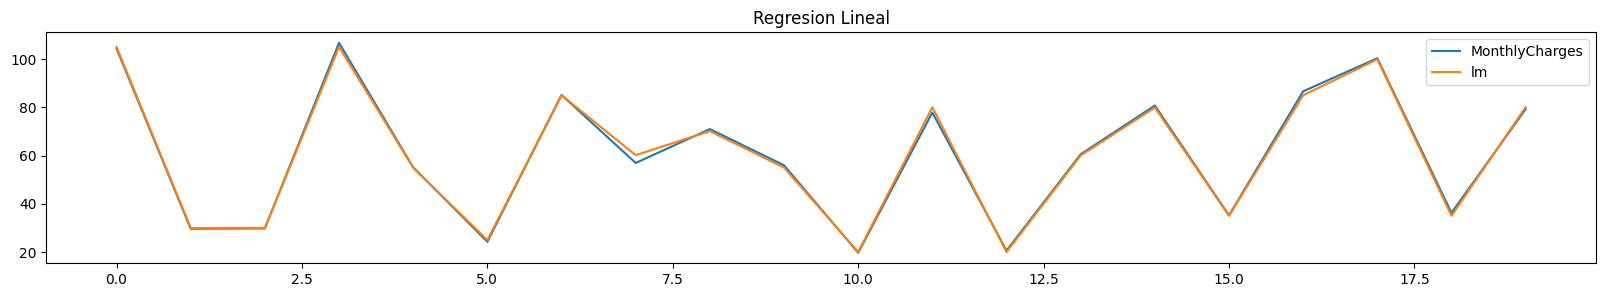

In [57]:
aux.head(20).plot(figsize=(20,3), title="Regresion Lineal")

# Logistic Regression

In [58]:
print(df.shape)
df.head()

(6961, 21)


customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity OnlineBackup  \
0  No phone service             DSL             No          Yes   
1                No             DSL            Yes           No   
2                No             DSL            Yes          Yes   
3  No phone service             DSL            Yes           No   
4                No     Fiber optic             No           No   

  DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  \
0               No          No          No              No  Month-to-month   
1              Yes          No          No              No        One year   
2               No          No          No              No  Month-to-month   
3              Yes         Yes          No              No        One year   
4               No          No          No              No  Month-to-month   

  PaperlessBilling              PaymentMethod  MonthlyCharges  TotalCharges  \
0              Yes           Electronic check           29.85         29.85   
1               No               Mailed check           56.95       1889.50   
2              Yes               Mailed check           53.85        108.15   
3               No  Bank transfer (automatic)           42.30       1840.75   
4              Yes           Electronic check           70.70        151.65   

  Churn  
0    No  
1    No  
2   Yes  
3    No  
4   Yes

In [59]:
varc, vard

(['tenure'],
 ['gender',
  'SeniorCitizen',
  'Partner',
  'Dependents',
  'PhoneService',
  'MultipleLines',
  'InternetService',
  'OnlineSecurity',
  'OnlineBackup',
  'DeviceProtection',
  'TechSupport',
  'StreamingTV',
  'StreamingMovies',
  'Contract',
  'PaperlessBilling',
  'PaymentMethod',
  'Churn'])

## Bivariate Analysis (Re-do)

In [60]:
varc = ["tenure", "MonthlyCharges", "TotalCharges"]
tgt = ["Churn"]
vard.remove("Churn")

In [61]:
vc = VarClusHi(df=df[varc], feat_list = varc)
vc.varclus()

In [62]:
rs = vc.rsquare
rs = rs.sort_values(by=['Cluster','RS_Ratio'] , ascending=[1,1]).reset_index(drop=True)

In [63]:
rs['id'] = rs.groupby('Cluster').cumcount()+1

In [64]:
rs

Cluster        Variable    RS_Own  RS_NC  RS_Ratio  id
0        0    TotalCharges  0.964994      0  0.035006   1
1        0          tenure  0.697533      0  0.302467   2
2        0  MonthlyCharges  0.499740      0  0.500260   3

array([[<AxesSubplot:title={'center':'TotalCharges'}>]], dtype=object)

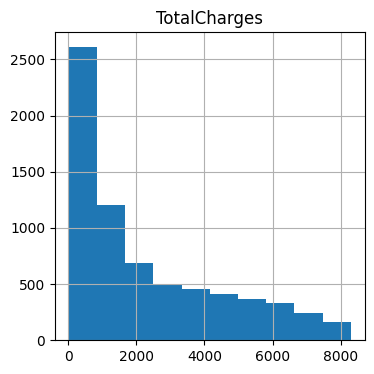

In [65]:
varc = rs.loc[ rs['id'] == 1 ]['Variable'].tolist()
df[varc].hist(figsize=(4,4))

In [66]:
X = df[varc+um].copy()

In [67]:
for v in varc:
    for k in range(2,6):
        X = discretizar(X,v,k)

In [68]:
X.head()

TotalCharges  customerID    d_TotalCharges_2    d_TotalCharges_3  \
0         29.85  7590-VHVEG  (19.549, 3134.432]  (19.549, 1992.383]   
1       1889.50  5575-GNVDE  (19.549, 3134.432]  (19.549, 1992.383]   
2        108.15  3668-QPYBK  (19.549, 3134.432]  (19.549, 1992.383]   
3       1840.75  7795-CFOCW  (19.549, 3134.432]  (19.549, 1992.383]   
4        151.65  9237-HQITU  (19.549, 3134.432]  (19.549, 1992.383]   

       d_TotalCharges_4     d_TotalCharges_5  
0    (19.549, 1212.693]    (19.549, 976.021]  
1  (1212.693, 3085.003]  (976.021, 2463.477]  
2    (19.549, 1212.693]    (19.549, 976.021]  
3  (1212.693, 3085.003]  (976.021, 2463.477]  
4    (19.549, 1212.693]    (19.549, 976.021]

In [69]:
vari = X.filter(like='d_').columns.tolist()

In [70]:
vari

['d_TotalCharges_2',
 'd_TotalCharges_3',
 'd_TotalCharges_4',
 'd_TotalCharges_5']

In [71]:
df.shape, X.shape

((6961, 21), (6961, 6))

In [72]:
X = X[um+vari].merge(  df[um+vard] , on = um , how='left' ).reset_index(drop=True)
y = X[um].merge(df[um+tgt], on=um, how='left').reset_index(drop=True)

In [73]:
X.shape, y.shape

((6961, 21), (6961, 2))

## Train, test, split

In [74]:
Xt, Xv, yt, yv = train_test_split(X, y, train_size=0.7 )

Xt = Xt.merge( yt, on=um, how='inner' ).reset_index(drop=True)

In [75]:
Xt.head()

customerID    d_TotalCharges_2      d_TotalCharges_3      d_TotalCharges_4  \
0  0224-RLWWD  (19.549, 3134.432]    (19.549, 1992.383]    (19.549, 1212.693]   
1  8003-EWNDZ  (19.549, 3134.432]    (19.549, 1992.383]    (19.549, 1212.693]   
2  2235-ZGKPT  (19.549, 3134.432]    (19.549, 1992.383]    (19.549, 1212.693]   
3  2325-ZUSFD  (3134.432, 8297.5]  (1992.383, 4757.862]  (3085.003, 5382.862]   
4  6463-MVYRY  (3134.432, 8297.5]  (1992.383, 4757.862]  (3085.003, 5382.862]   

      d_TotalCharges_5  gender  SeniorCitizen Partner Dependents PhoneService  \
0    (19.549, 976.021]  Female              1      No         No          Yes   
1    (19.549, 976.021]  Female              0      No         No          Yes   
2    (19.549, 976.021]  Female              0     Yes        Yes          Yes   
3  (2463.477, 4244.18]  Female              0     Yes        Yes          Yes   
4  (2463.477, 4244.18]  Female              1      No         No          Yes   

  MultipleLines InternetService       OnlineSecurity         OnlineBackup  \
0            No             DSL                   No                   No   
1            No              No  No internet service  No internet service   
2           Yes             DSL                   No                   No   
3            No             DSL                  Yes                   No   
4            No             DSL                  Yes                   No   

      DeviceProtection          TechSupport          StreamingTV  \
0                   No                   No                   No   
1  No internet service  No internet service  No internet service   
2                   No                   No                   No   
3                   No                   No                  Yes   
4                  Yes                  Yes                  Yes   

       StreamingMovies        Contract PaperlessBilling  \
0                   No  Month-to-month              Yes   
1  No internet service  Month-to-month              Yes   
2                   No  Month-to-month               No   
3                  Yes        One year              Yes   
4                   No        Two year               No   

               PaymentMethod Churn  
0           Electronic check    No  
1           Electronic check    No  
2               Mailed check   Yes  
3  Bank transfer (automatic)   Yes  
4  Bank transfer (automatic)    No

## Best Discretized Variables (IV function)

In [76]:
iv = pd.DataFrame( map( lambda v: calculo_iv(Xt,v,tgt,um[0]), vari  ), columns=['variable','iv']  )
iv['raiz'] = iv['variable'].map(lambda x: '_'.join(x.split('_')[1:2] )  )
iv = iv.sort_values(by=['raiz','iv'],ascending=[1,0]).reset_index(drop=True)

In [77]:
iv['id'] = iv.groupby('raiz').cumcount()+1
iv = iv.loc[iv['id'] == 1]

In [78]:
besti = iv['variable'].tolist()
len(besti), besti

(1, ['d_TotalCharges_5'])

## Best Normalized Variables

In [79]:
ivd = pd.DataFrame(map(lambda v:calculo_iv(Xt,v,tgt,um[0]),vard),columns=['variable','iv'])
ivd

variable        iv
0             gender  0.000336
1      SeniorCitizen  0.103831
2            Partner  0.104913
3         Dependents  0.143659
4       PhoneService  0.000611
5      MultipleLines  0.007876
6    InternetService  0.665509
7     OnlineSecurity  0.762835
8       OnlineBackup  0.571517
9   DeviceProtection  0.548730
10       TechSupport  0.749365
11       StreamingTV  0.436497
12   StreamingMovies  0.433672
13          Contract  1.265940
14  PaperlessBilling  0.225706
15     PaymentMethod  0.480785

In [80]:
iv = pd.concat([iv,ivd],ignore_index=True)
iv = iv.loc[iv['iv'] != np.inf].reset_index(drop=True)
iv = iv.loc[~np.isinf(iv['iv'])].reset_index(drop=True)

In [81]:
iv.drop(['raiz','id'],axis=1,inplace=True)

In [82]:
iv.sort_values(by='iv',ascending=False)

variable        iv
14          Contract  1.265940
8     OnlineSecurity  0.762835
11       TechSupport  0.749365
7    InternetService  0.665509
9       OnlineBackup  0.571517
10  DeviceProtection  0.548730
16     PaymentMethod  0.480785
12       StreamingTV  0.436497
13   StreamingMovies  0.433672
0   d_TotalCharges_5  0.246539
15  PaperlessBilling  0.225706
4         Dependents  0.143659
3            Partner  0.104913
2      SeniorCitizen  0.103831
6      MultipleLines  0.007876
5       PhoneService  0.000611
1             gender  0.000336

In [83]:
best = iv.loc[ (iv['iv'] > 0.005 ) &  ( iv['iv'] < 0.5) ]['variable'].tolist()

## WoE Transformation

In [84]:
X = X[um + best].reset_index(drop=True)

In [85]:
X.shape, y.shape

((6961, 10), (6961, 2))

In [86]:
Xt, Xv,yt,yv = train_test_split(X,y,train_size=0.7)
Xt = Xt.merge(yt,on=um,how='inner')

### WoE map

In [87]:
woe_map = list(map( lambda v: codificacion_woe(  Xt , v, tgt, um[0] ), best  ))

In [88]:
for v, mapa in woe_map:
    Xt[f'w_{v}'] = Xt[v].replace(mapa)
    Xv[f'w_{v}'] = Xv[v].replace(mapa)

In [89]:
varw = Xt.filter(like='w_').columns.tolist()

In [90]:
varw

['w_d_TotalCharges_5',
 'w_SeniorCitizen',
 'w_Partner',
 'w_Dependents',
 'w_MultipleLines',
 'w_StreamingTV',
 'w_StreamingMovies',
 'w_PaperlessBilling',
 'w_PaymentMethod']

## TAD

In [91]:
tad = Xt[um + varw].merge(yt, on = um, how='inner').reset_index(drop=True)

In [92]:
tad.head()

customerID  w_d_TotalCharges_5  w_SeniorCitizen  w_Partner  w_Dependents  \
0  0305-SQECB           -0.517823         0.139386  -0.350439      0.721023   
1  2961-VNFKL            0.237484         0.139386   0.436064     -0.235899   
2  4361-BKAXE            0.723290         0.139386  -0.350439     -0.235899   
3  3026-ATZYV            0.300399         0.139386   0.436064      0.721023   
4  2096-XOTMO           -0.517823         0.139386   0.436064      0.721023   

   w_MultipleLines  w_StreamingTV  w_StreamingMovies  w_PaperlessBilling  \
0         0.048790      -0.331529          -0.363747           -0.337931   
1        -0.086290       1.619105           1.619105           -0.337931   
2        -0.086290      -0.185934          -0.152022           -0.337931   
3         0.069907      -0.185934          -0.152022            0.608575   
4         0.069907       1.619105           1.619105            0.608575   

   w_PaymentMethod Churn  
0         0.453557    No  
1         0.705248    No  
2         0.585768   Yes  
3         0.585768    No  
4         0.453557    No

## Model

In [93]:
Xt, Xv, yt, yv = train_test_split(tad[varw], tad[tgt], train_size=0.7 )

In [94]:
Xt.head()

w_d_TotalCharges_5  w_SeniorCitizen  w_Partner  w_Dependents  \
3555            0.300399         0.139386  -0.350439     -0.235899   
3696            0.723290         0.139386  -0.350439     -0.235899   
1737           -0.517823         0.139386  -0.350439     -0.235899   
2221           -0.517823        -0.607348  -0.350439     -0.235899   
4295           -0.517823         0.139386   0.436064     -0.235899   

      w_MultipleLines  w_StreamingTV  w_StreamingMovies  w_PaperlessBilling  \
3555        -0.086290      -0.331529          -0.363747            0.608575   
3696        -0.086290      -0.331529          -0.152022            0.608575   
1737         0.069907      -0.185934          -0.363747           -0.337931   
2221        -0.086290      -0.331529          -0.363747           -0.337931   
4295         0.069907       1.619105           1.619105            0.608575   

      w_PaymentMethod  
3555        -0.851091  
3696         0.705248  
1737         0.705248  
2221        -0.851091  
4295         0.453557

In [95]:
Log_Reg = LogisticRegression()

In [96]:
Log_Reg.fit(Xt,yt)

C:\Users\David\OneDrive\Documentos\Diplomado\diplo\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

In [97]:
Log_Reg.predict(Xv)

array(['No', 'No', 'Yes', ..., 'Yes', 'No', 'No'], dtype=object)

In [98]:
Log_Reg.predict_proba(Xv)

array([[0.93808428, 0.06191572],
       [0.73080812, 0.26919188],
       [0.43846964, 0.56153036],
       ...,
       [0.25418377, 0.74581623],
       [0.87048665, 0.12951335],
       [0.88115871, 0.11884129]])

In [99]:
metrics_Logistic(Log_Reg, Xt, yt)

 Roc Validate: 0.803
 Acc Validate: 0.780
 Matrix Conf Validate:  
 [[2292  208]
 [ 543  367]]


In [100]:
metrics_Logistic(Log_Reg, Xv, yv)

 Roc Validate: 0.795
 Acc Validate: 0.777
 Matrix Conf Validate:  
 [[986  84]
 [242 150]]


In [101]:
f1_score(y_pred=Log_Reg.predict(Xv),y_true=yv, pos_label="Yes")

0.4792332268370607

In [102]:
f1_score(y_pred=Log_Reg.predict(Xv), y_true=yv, pos_label="No")

0.8581375108790251

In [103]:
print(classification_report(yv, Log_Reg.predict(Xv)))

              precision    recall  f1-score   support

          No       0.80      0.92      0.86      1070
         Yes       0.64      0.38      0.48       392

    accuracy                           0.78      1462
   macro avg       0.72      0.65      0.67      1462
weighted avg       0.76      0.78      0.76      1462



In [104]:
'''

fpr, tpr, thresh = roc_curve(y_true=yv, y_score=Log_Reg.predict_proba(Xv)[:,1], pos_label=0)
plt.title('Receiver Operating Characteristic')
auc = roc_auc_score(y_true=Xv, y_score=Log_Reg.predict_proba(Xv)[:,1])
plt.plot(fpr, tpr, 'b', label = f'AUC = {auc.round(2)}')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

'''

"\n\nfpr, tpr, thresh = roc_curve(y_true=yv, y_score=Log_Reg.predict_proba(Xv)[:,1], pos_label=0)\nplt.title('Receiver Operating Characteristic')\nauc = roc_auc_score(y_true=Xv, y_score=Log_Reg.predict_proba(Xv)[:,1])\nplt.plot(fpr, tpr, 'b', label = f'AUC = {auc.round(2)}')\nplt.legend(loc = 'lower right')\nplt.plot([0, 1], [0, 1],'r--')\nplt.xlim([0, 1])\nplt.ylim([0, 1])\nplt.ylabel('True Positive Rate')\nplt.xlabel('False Positive Rate')\nplt.show()\n\n"

C:\Users\David\OneDrive\Documentos\Diplomado\diplo\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


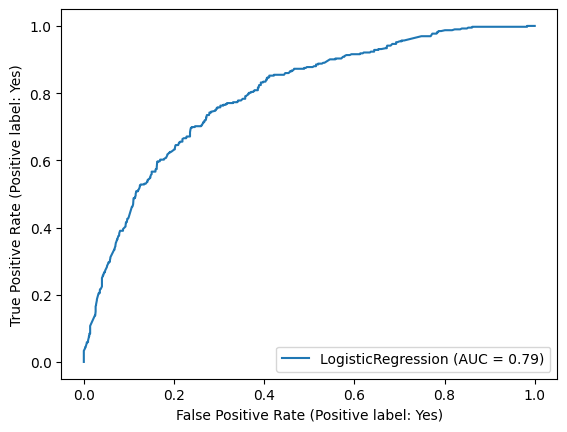

In [105]:
plot_roc_curve(Log_Reg, Xv, yv)

# Useful info

In [106]:
Churned = df[df["Churn"] == "Yes"]
nonChurned = df[df["Churn"] == "No"]
aux.head()

MonthlyCharges          lm
0          104.30  104.934298
1           29.65   29.938143
2           29.80   30.012972
3          106.70  104.966524
4           55.05   54.926424

<AxesSubplot:>

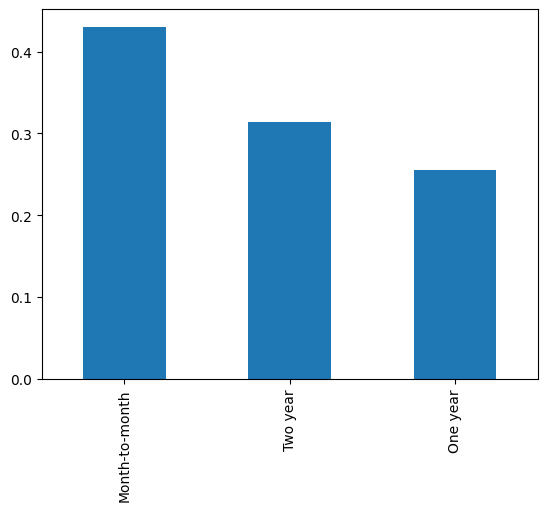

In [107]:
nonChurned["Contract"].value_counts(normalize=True).plot(kind="bar")

<AxesSubplot:>

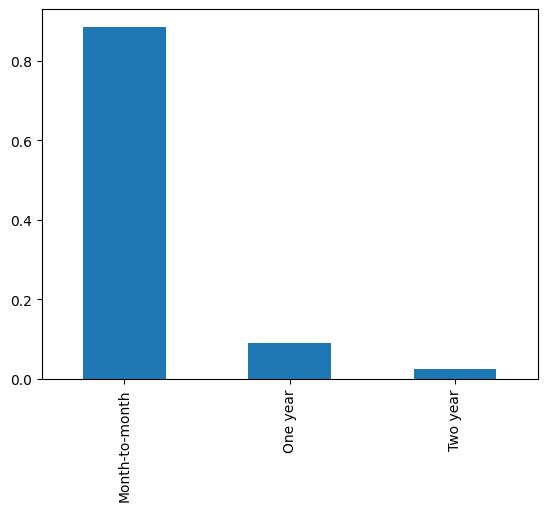

In [108]:
Churned["Contract"].value_counts(normalize=True).plot(kind="bar")

<AxesSubplot:>

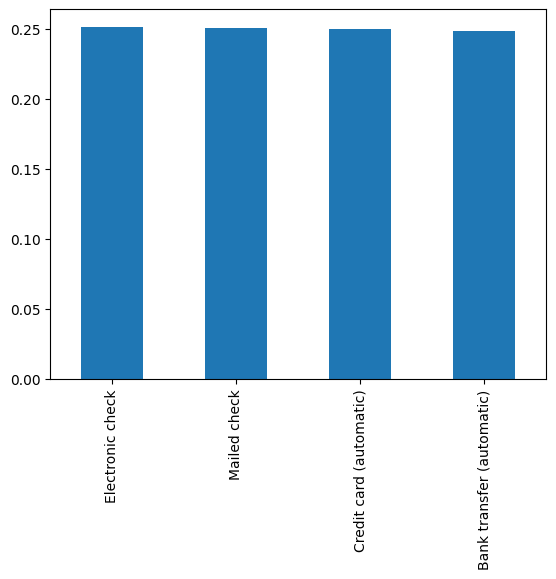

In [109]:
nonChurned["PaymentMethod"].value_counts(normalize=True).plot(kind="bar")

<AxesSubplot:>

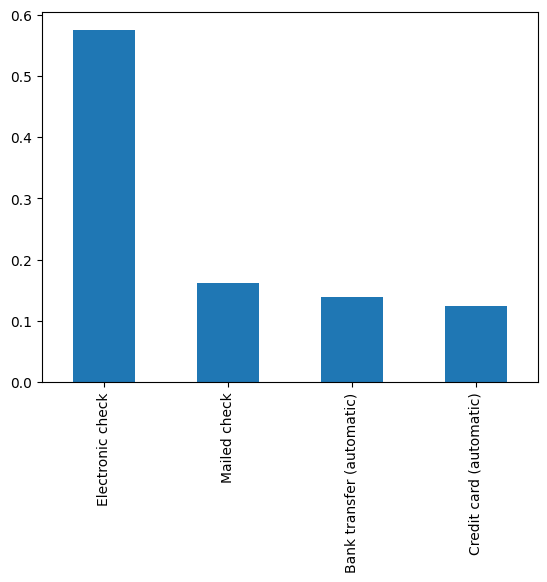

In [110]:
Churned["PaymentMethod"].value_counts(normalize=True).plot(kind="bar")

<AxesSubplot:>

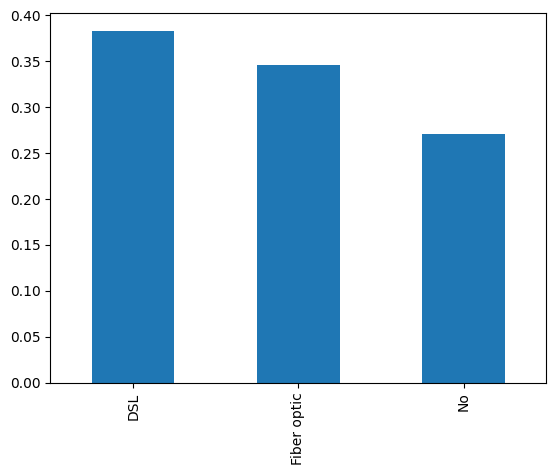

In [111]:
nonChurned["InternetService"].value_counts(normalize=True).plot(kind="bar")

<AxesSubplot:>

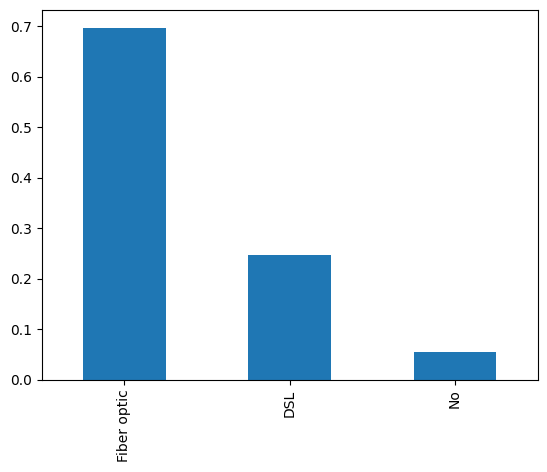

In [112]:
Churned["InternetService"].value_counts(normalize=True).plot(kind="bar")